In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_labeled= pd.read_csv('/content/drive/My Drive/Master_Thesis/new_labeled_dataset.csv')
df_labeled


,generated_summary,labels
0,i understand that when someone immediately off...,2
1,i'm here to welcome you to the r/depression ch...,1
2,i stay up all night when i'm depressed to dela...,2
3,"i have procrastinated a lot in my life, avoidi...",2
4,i find that sleep is my ultimate escape and so...,1
...,...,...
7726,i see snow.,0
7727,i watched moulin rouge and it made me cry once...,0
7728,"i am attempting to call out, but i am unable t...",0
7729,"i can't find my red sox hat, so i have to wear...",0


In [ ]:
import joblib

import joblib
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    # Convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return lemmas

def preprocessing(text):
    lower_text = text.lower()
    punctuation_free = "".join([chars for chars in lower_text if chars not in string.punctuation])
    remove_urls = re.sub(r'http\S+', '', punctuation_free)
    remove_digits = re.sub(r'\d', '', remove_urls)
    tokenized_text = word_tokenize(remove_digits)

    # Remove stop words
    filtered_tokens = [token for token in tokenized_text if token not in stop_words]

    # Lemmatize tokens
    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    return lemmatized_tokens

best_tfidf_vectorizer = joblib.load('/content/drive/My Drive/Master_Thesis/best_tfidf_vectorizer.pkl')

In [ ]:
X_train=joblib.load('/content/drive/My Drive/Master_Thesis/X_train.pkl')
y_train=joblib.load('/content/drive/My Drive/Master_Thesis/y_train.pkl')
X_test=joblib.load('/content/drive/My Drive/Master_Thesis/X_test.pkl')
y_test=joblib.load('/content/drive/My Drive/Master_Thesis/y_test.pkl')

In [ ]:
# Fit TF-IDF vectorizer with training data and transform both training and testing data


import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import RandomizedSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

X_train_tfidf = best_tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = best_tfidf_vectorizer.transform(X_test)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make', 'u'] not in stop_words.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import xgboost as xgb


# Compute sample weights for imbalanced classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

param_dist = {
    'learning_rate': [0.01, 0.05, 0.016, 0.08, 0.16, 0.23, 0.3],
     'gamma': [0, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'n_estimators': [120, 195],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5, 7],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 1]
}

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(objective='multi:softprob')

# Perform Randomized Search CV with F1 scoring
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    random_state=42,
    return_train_score=True
)

xgb_random_search.fit(X_train_tfidf, y_train, sample_weight=sample_weights)

print("Best F1 Score: %f using %s" % (xgb_random_search.best_score_, xgb_random_search.best_params_))

best_xgb_params = xgb_random_search.best_params_

print("Best parameters found: ", best_xgb_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best F1 Score: 0.818528 using {'n_estimators': 120, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.23, 'lambda': 0.04, 'gamma': 0.7, 'alpha': 0.1}
Best parameters found:  {'n_estimators': 120, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.23, 'lambda': 0.04, 'gamma': 0.7, 'alpha': 0.1}


In [ ]:
best_xgb_classifier = xgb.XGBClassifier(**best_xgb_params)

best_xgb_classifier.fit(X_train_tfidf, y_train, sample_weight=sample_weights)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.7, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.04, learning_rate=0.23,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None, ...)

In [ ]:
import joblib

joblib.dump(best_xgb_classifier, '/content/drive/My Drive/Master_Thesis/best_xgb_model.pkl')


['/content/drive/My Drive/Master_Thesis/best_xgb_model.pkl']

In [ ]:
import joblib
import xgboost as xgb

best_xgb_classifier = joblib.load('/content/drive/My Drive/Master_Thesis/best_xgb_model.pkl')


In [ ]:
import joblib

import joblib
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return lemmas

def preprocessing(text):
    lower_text = text.lower()
    punctuation_free = "".join([chars for chars in lower_text if chars not in string.punctuation])
    remove_urls = re.sub(r'http\S+', '', punctuation_free)
    remove_digits = re.sub(r'\d', '', remove_urls)
    tokenized_text = word_tokenize(remove_digits)

    filtered_tokens = [token for token in tokenized_text if token not in stop_words]

    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    return lemmatized_tokens

# Load the pickled TF-IDF vectorizer
best_tfidf_vectorizer = joblib.load('/content/drive/My Drive/Master_Thesis/best_tfidf_vectorizer.pkl')

In [ ]:
# Fit TF-IDF vectorizer with training data and transform both training and testing data
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

X_train_tfidf = best_tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = best_tfidf_vectorizer.transform(X_test)






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make', 'u'] not in stop_words.
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report
best_xgb_classifier.fit(X_train_tfidf, y_train)

y_pred = best_xgb_classifier.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.98      0.93       780
           1       0.71      0.73      0.72       252
           2       0.75      0.74      0.75       279
           3       0.75      0.51      0.60       236

    accuracy                           0.82      1547
   macro avg       0.78      0.74      0.75      1547
weighted avg       0.82      0.82      0.81      1547



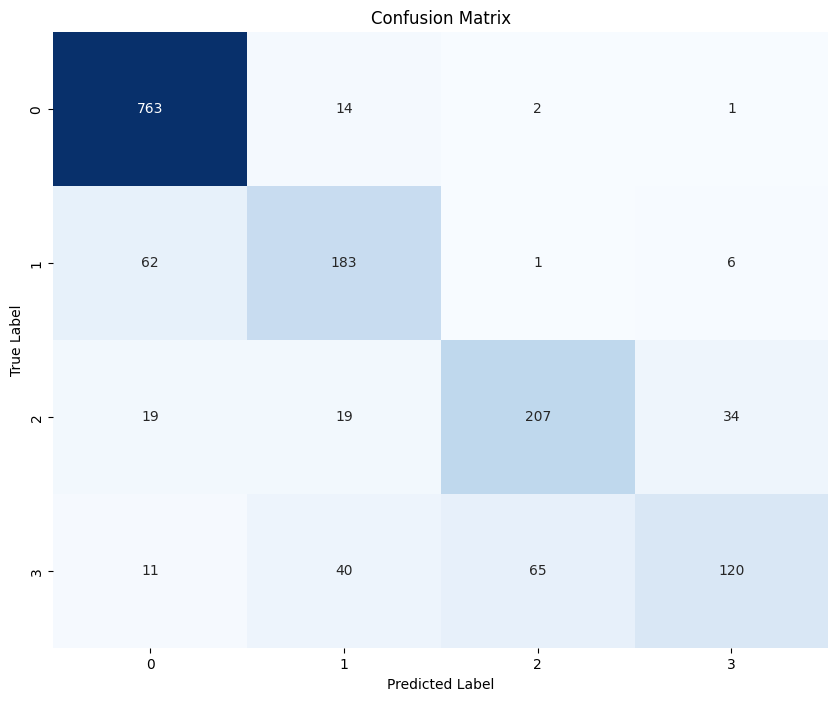

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/My Drive/Master_Thesis/confusion matrix XGBoost.png')
plt.show()

In [ ]:
!pip show scikit-learn


Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


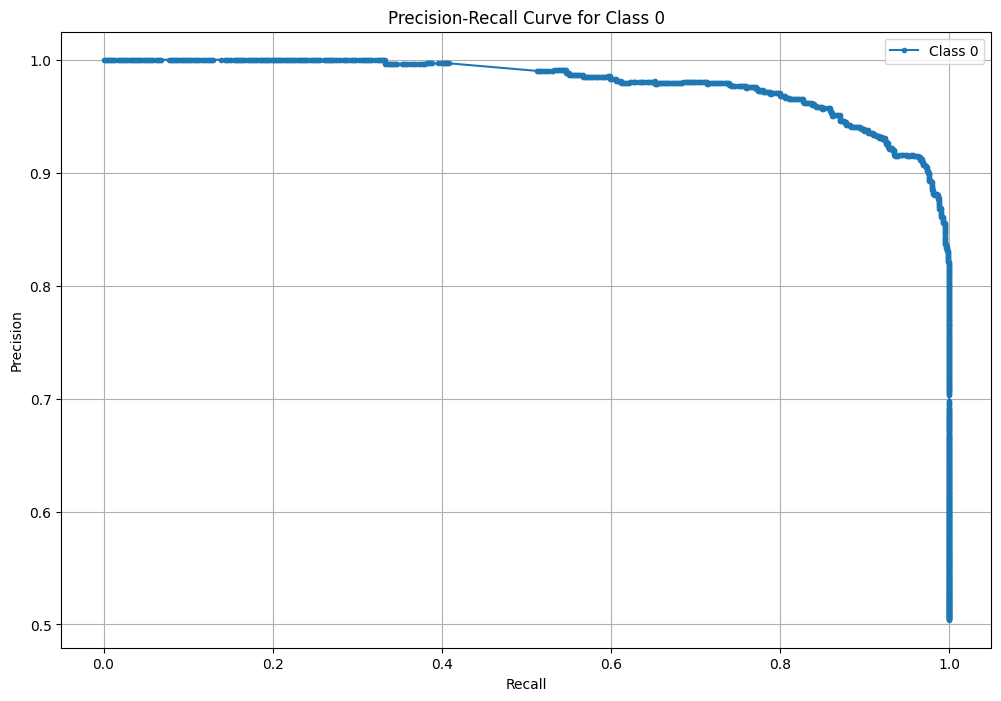

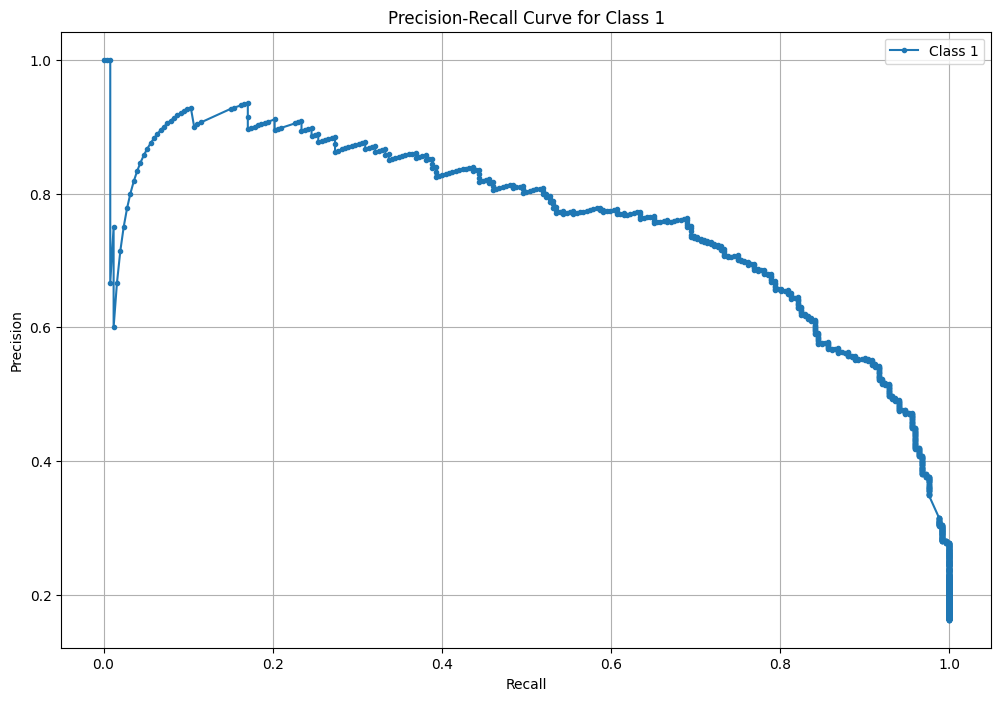

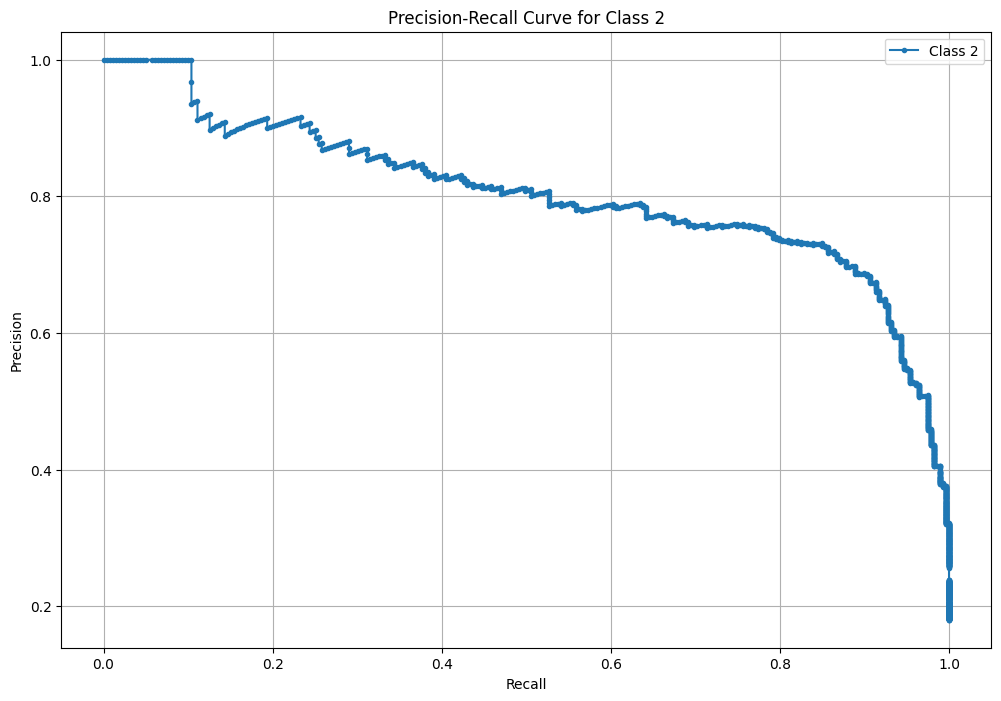

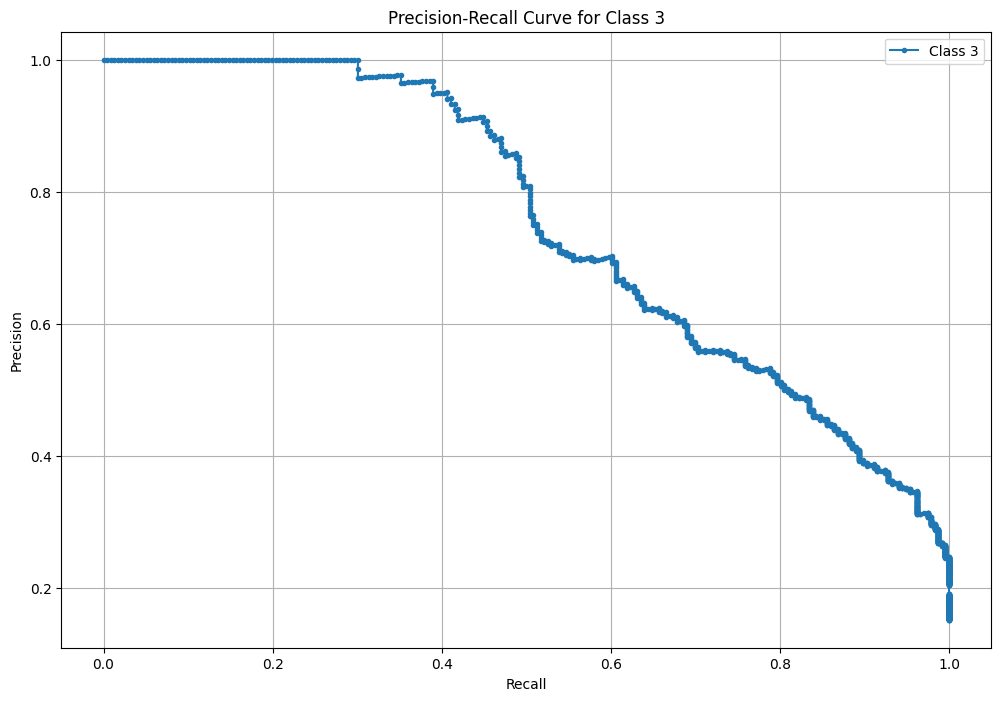

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, classification_report
from matplotlib import pyplot as plt
import nltk

y_probas = best_xgb_classifier.predict_proba(X_test_tfidf)

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

precisions = dict()
recalls = dict()
thresholds = dict()
for i in range(len(np.unique(y_test))):
    precisions[i], recalls[i], thresholds[i] = precision_recall_curve(y_test_bin[:, i], y_probas[:, i])

# Plot Precision-Recall Curve for each class separately
for i in range(len(np.unique(y_test))):
    plt.figure(figsize=(12, 8))
    plt.plot(recalls[i], precisions[i], marker='.', label='Class {}'.format(i))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Class {}'.format(i))
    plt.legend()
    plt.grid(True)
    plt.savefig('/content/drive/My Drive/Master_Thesis/Precision-Recall Curve for Class {}.png'.format(i))  # Save the plot with filename based on class number
    plt.show()

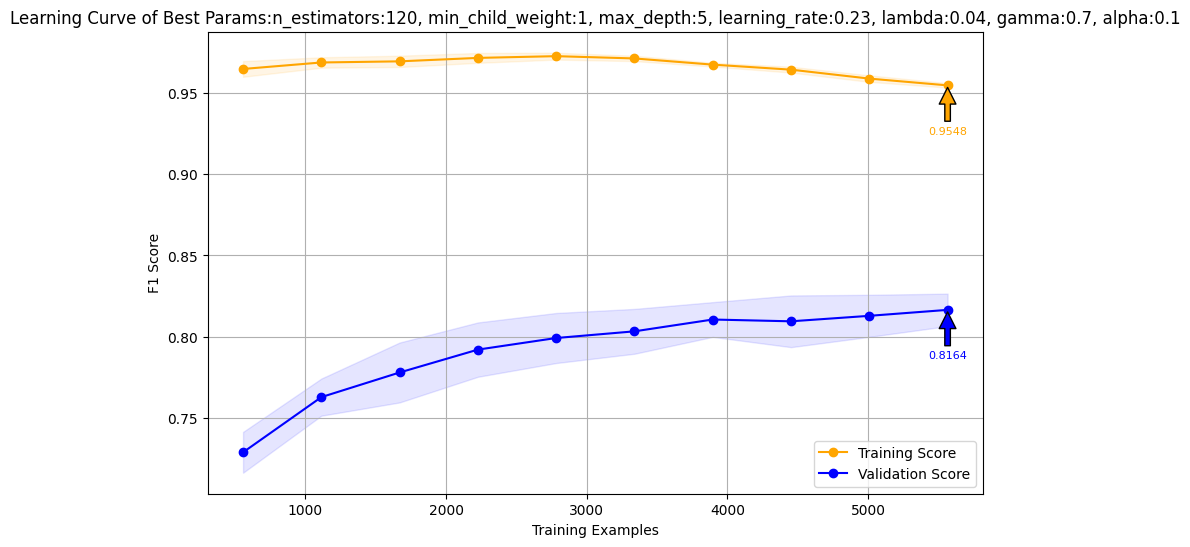

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt


train_sizes, train_scores, valid_scores = learning_curve(
    best_xgb_classifier, X_train_tfidf, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='f1_weighted', cv=10, shuffle=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

final_train_f1_mean = train_scores_mean[-1]
final_valid_f1_mean = valid_scores_mean[-1]

plt.figure(figsize=(10, 6))
plt.title('Learning Curve of Best Params:n_estimators:120, min_child_weight:1, max_depth:5, learning_rate:0.23, lambda:0.04, gamma:0.7, alpha:0.1')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="orange")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="blue")
plt.plot(train_sizes, train_scores_mean, 'o-', color="orange", label="Training Score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="blue", label="Validation Score")
plt.annotate(f'{final_train_f1_mean:.4f}',
             xy=(train_sizes[-1], final_train_f1_mean),
             xytext=(train_sizes[-1], final_train_f1_mean- 0.03),
             arrowprops=dict(facecolor='orange', shrink=0.05),
             fontsize=8, color='orange', ha='center')

plt.annotate(f'{final_valid_f1_mean:.4f}',
             xy=(train_sizes[-1], final_valid_f1_mean),
             xytext=(train_sizes[-1], final_valid_f1_mean- 0.03),
             arrowprops=dict(facecolor='blue', shrink=0.05),
             fontsize=8, color='blue', ha='center')

plt.legend(loc="best")
plt.grid()
plt.savefig('/content/drive/My Drive/Master_Thesis/learning_curve_best_params_XGBoost.png')  # Save the plot with filename based on class number

plt.show()

In [ ]:
import numpy as np

y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Get the misclassified instances
misclassified_indices = np.where(y_test != y_pred)[0]

X_misclassified = X_test.iloc[misclassified_indices]
y_misclassified = y_test[misclassified_indices]

print("Misclassified instances:")
print(X_misclassified)
print(y_misclassified)


Misclassified instances:
476     i don't think i'm being irrational. i know tha...
1261    i should stop being myself, a disaster, a disa...
3427    i have another meeting with my counselor tomor...
2177    i am sorry, but the text "this is it" is too s...
605     i am excited because i have something to look ...
                              ...                        
1459    i want to speak with someone who is not from m...
2451    i have seen it all out here. i have dealt with...
3378    i will not believe in depression but still say...
702     i am a 9-year-old from india going through a m...
510     i just want to stop being so sad. i feel like ...
Name: generated_summary, Length: 274, dtype: object
[2 1 3 1 1 1 3 3 1 1 2 3 3 1 2 0 3 2 2 3 2 2 2 0 3 3 3 3 2 3 1 0 1 2 2 2 0
 2 2 1 2 1 1 3 2 2 2 3 2 3 1 3 2 3 3 3 3 1 2 3 1 2 1 2 3 3 3 3 2 2 2 3 2 2
 3 3 3 1 2 3 3 3 2 3 3 2 2 3 1 2 2 3 3 3 3 1 3 3 3 1 1 3 2 1 2 2 3 1 3 1 2
 3 2 3 2 1 1 3 3 2 3 2 3 2 3 3 3 1 3 3 1 1 0 1 1 3 0 3 2 1 3

In [ ]:
import pandas as pd

y_misclassified_series = pd.Series(y_misclassified)
misclassified_distribution = y_misclassified_series.value_counts().sort_index()

print("Misclassified distribution:")
print(misclassified_distribution)

Misclassified distribution:
0     17
1     69
2     72
3    116
Name: count, dtype: int64


In [ ]:

y_train_series = pd.Series(y_train)
train_distribution = y_train_series.value_counts().sort_index()

print("Training distribution:")
print(train_distribution)

y_test_series = pd.Series(y_test)
test_distribution = y_test_series.value_counts().sort_index()

print("Testing distribution:")
print(test_distribution)


Training distribution:
labels
0    3120
1    1007
2    1116
3     941
Name: count, dtype: int64
Testing distribution:
0    780
1    252
2    279
3    236
Name: count, dtype: int64


In [ ]:
misclassified_df = pd.DataFrame({'X': X_misclassified.tolist(), 'y': y_misclassified})


In [ ]:

####taking a sample to hupertune the temperatureand cosine similarity:

sampled_misclassified = misclassified_df.groupby('y').apply(lambda x: x.sample(n=2, random_state=42)).reset_index(drop=True)

X_sampled = sampled_misclassified['X'].tolist()
y_sampled = sampled_misclassified['y'].tolist()

X_sampled_df = pd.DataFrame(X_sampled, columns=['X'])

print("Sampled misclassified instances:")
print(X_sampled_df)
print(y_sampled)


Sampled misclassified instances:
                                                   X
0  i am still struggling to grasp the purpose of ...
1  i'm sorry, but i cannot provide a   without th...
2  i feel overwhelmed by the amount of work. how ...
3  i should stop being myself, a disaster, a disa...
4  i went to the doctor's office and my blood pre...
5  i had a panic attack during 1st period after s...
6  i matched with a guy on a dating app, went on ...
7  i will see a 0 0 when i slit my wrist at this ...
[0, 0, 1, 1, 2, 2, 3, 3]


In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00


In [ ]:
OPENAI_API_KEY = " "


In [ ]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import os
import openai
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

X_augmented = []
y_augmented = []
if 'OPENAI_API_KEY' in os.environ:
    openai.api_key = os.environ['OPENAI_API_KEY']
else:
    openai.api_key = OPENAI_API_KEY

def generate_augmented_data(instance, label,temperature,top_p, num_samples=2):
    augmented_data = []

    for _ in range(num_samples):
        response =  openai.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=temperature,
            max_tokens=350,
            top_p=top_p,
            messages=[
                {
                    "role": "system",
                    "content": "You are an expert synthetic generator."
                },
                {
                    "role": "user",
                    "content": f"""Generate synthetic examples similar to the post of class {label} that have same word of
 feelings as the following reddit posts:\n\n{instance}\n\n while maintaining relevance."""
                }
            ]
        )
        augmented_data.append(response.choices[0].message.content.strip().lower())

    return augmented_data


In [ ]:
# Generate and evaluate synthetic data for each temperature
def calculate_similarity(original, synthetic):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([original] + synthetic)
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    return cosine_similarities

temperatures = np.arange(0.00, 1.1, 0.1)
top_p_values = np.arange(0.0, 1.1, 0.5)

similarity_results = {top_p: {temp: [] for temp in temperatures} for top_p in top_p_values}

for top_p in top_p_values:
    for temperature in temperatures:
        for idx, original_instance in X_sampled_df.iterrows():
            label = y_sampled[idx]
            synthetic_samples = generate_augmented_data(original_instance['X'], label, temperature, top_p, num_samples=3)
            similarities = calculate_similarity(original_instance['X'], synthetic_samples)
            similarity_results[top_p][temperature].extend(similarities)

# Calculate average similarity for each temperature and top_p value
average_similarities = {top_p: {temp: np.mean(similarities) for temp, similarities in similarity_results[top_p].items()} for top_p in top_p_values}

# Plot the results for each top_p value
plt.figure(figsize=(12, 8))
for top_p, avg_similarities in average_similarities.items():
    plt.plot(temperatures, list(avg_similarities.values()), marker='o', label=f'Top P: {top_p}')
plt.title('Cosine Similarity vs. Temperature (range(0.00, 1.1, 0.1)) for Different Top P Values (range(0.0, 1.1, 0.5))')
plt.xlabel('Temperature')
plt.ylabel('Average Cosine Similarity')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/My Drive/Master_Thesis/Cosine Similarity vs. Temperature for Different Top P Values0-1,1.png')
plt.show()

In [ ]:
# Generate and evaluate synthetic data for each temperature
def calculate_similarity(original, synthetic):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([original] + synthetic)
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    return cosine_similarities

temperatures = np.arange(0.00, 1.1, 0.1)
top_p_values = np.arange(0.0, 0.5, 0.1)

similarity_results = {top_p: {temp: [] for temp in temperatures} for top_p in top_p_values}

for top_p in top_p_values:
    for temperature in temperatures:
        for idx, original_instance in X_sampled_df.iterrows():
            label = y_sampled[idx]
            synthetic_samples = generate_augmented_data(original_instance['X'], label, temperature, top_p, num_samples=3)
            similarities = calculate_similarity(original_instance['X'], synthetic_samples)
            similarity_results[top_p][temperature].extend(similarities)

average_similarities = {top_p: {temp: np.mean(similarities) for temp, similarities in similarity_results[top_p].items()} for top_p in top_p_values}

plt.figure(figsize=(12, 8))
for top_p, avg_similarities in average_similarities.items():
    plt.plot(temperatures, list(avg_similarities.values()), marker='o', label=f'Top P: {top_p}')
plt.title('Cosine Similarity vs. Temperature (range(0.00, 1.1, 0.1)) for Different Top P Values (range(0.0, 0.5, 0.1))')
plt.xlabel('Temperature')
plt.ylabel('Average Cosine Similarity')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/My Drive/Master_Thesis/Cosine Similarity vs. Temperature for Different Top P Values0-0,5.png')
plt.show()

In [ ]:
def calculate_similarity(original, synthetic):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([original] + synthetic)
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    return cosine_similarities

temperatures = np.arange(0.00, 1.1, 0.1)
top_p_values = np.arange(0.5, 1.1, 0.1)

similarity_results = {top_p: {temp: [] for temp in temperatures} for top_p in top_p_values}

for top_p in top_p_values:
    for temperature in temperatures:
        for idx, original_instance in X_sampled_df.iterrows():
            label = y_sampled[idx]
            synthetic_samples = generate_augmented_data(original_instance['X'], label, temperature, top_p, num_samples=3)
            similarities = calculate_similarity(original_instance['X'], synthetic_samples)
            similarity_results[top_p][temperature].extend(similarities)

# Calculate average similarity for each temperature and top_p value
average_similarities = {top_p: {temp: np.mean(similarities) for temp, similarities in similarity_results[top_p].items()} for top_p in top_p_values}

# Plot the results for each top_p value
plt.figure(figsize=(12, 8))
for top_p, avg_similarities in average_similarities.items():
    plt.plot(temperatures, list(avg_similarities.values()), marker='o', label=f'Top P: {top_p}')
plt.title('Cosine Similarity vs. Temperature (range(0.00, 1.1, 0.1)) for Different Top P Values (range(0.5, 1.1, 0.1))')
plt.xlabel('Temperature')
plt.ylabel('Average Cosine Similarity')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/My Drive/Master_Thesis/Cosine Similarity vs. Temperature for Different Top P Values0.5-1,1.png')
plt.show()

In [ ]:
def calculate_similarity(original, synthetic):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([original] + synthetic)
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    return cosine_similarities

temperatures = np.arange(0.00, 1.1, 0.1)
top_p_values = np.arange(0.0, 1.1, 0.1)

similarity_results = {top_p: {temp: [] for temp in temperatures} for top_p in top_p_values}

# Generate and evaluate synthetic data for each temperature and top_p value
for top_p in top_p_values:
    for temperature in temperatures:
        for idx, original_instance in X_sampled_df.iterrows():
            label = y_sampled[idx]
            synthetic_samples = generate_augmented_data(original_instance['X'], label, temperature, top_p, num_samples=3)
            similarities = calculate_similarity(original_instance['X'], synthetic_samples)
            similarity_results[top_p][temperature].extend(similarities)

average_similarities = {top_p: {temp: np.mean(similarities) for temp, similarities in similarity_results[top_p].items()} for top_p in top_p_values}

# Plot the results for each top_p value
plt.figure(figsize=(12, 8))
for top_p, avg_similarities in average_similarities.items():
    plt.plot(temperatures, list(avg_similarities.values()), marker='o', label=f'Top P: {top_p}')
plt.title('Cosine Similarity vs. Temperature for Different Top P Values')
plt.xlabel('Temperature')
plt.ylabel('Average Cosine Similarity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def calculate_similarity(original, synthetic):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([original] + synthetic)
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    return cosine_similarities

temperatures = np.arange(0.05, 0.51, 0.05)
top_p_values = np.arange(0.0, 1.1, 0.5)

similarity_results = {top_p: {temp: [] for temp in temperatures} for top_p in top_p_values}

for top_p in top_p_values:
    for temperature in temperatures:
        for idx, original_instance in X_sampled_df.iterrows():
            label = y_sampled[idx]
            synthetic_samples = generate_augmented_data(original_instance['X'], label, temperature, top_p, num_samples=3)
            similarities = calculate_similarity(original_instance['X'], synthetic_samples)
            similarity_results[top_p][temperature].extend(similarities)

# Calculate average similarity for each temperature and top_p value
average_similarities = {top_p: {temp: np.mean(similarities) for temp, similarities in similarity_results[top_p].items()} for top_p in top_p_values}

# Plot the results for each top_p value separately
for top_p, avg_similarities in average_similarities.items():
    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, list(avg_similarities.values()), marker='o', label=f'Top P: {top_p}')
    plt.title(f'Cosine Similarity vs. Temperature for Top P: {top_p}')
    plt.xlabel('Temperature')
    plt.ylabel('Average Cosine Similarity')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Generate and evaluate synthetic data for each temperature
def calculate_similarity(original, synthetic):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([original] + synthetic)
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    return cosine_similarities

temperatures = temperatures = np.arange(0.05, 0.51, 0.05)

similarity_results = {temp: [] for temp in temperatures}
for temperature in temperatures:
    print(f"Temperature: {temperature}")
    for idx, original_instance in X_sampled_df.iterrows():
        label = y_sampled[idx]
        synthetic_samples = generate_augmented_data(original_instance['X'], label, temperature, num_samples=3)
        similarities = calculate_similarity(original_instance['X'], synthetic_samples)
        print(f"Original instance (Class {label}): {original_instance['X']}")
        print("Similarities with synthetic samples:", similarities)
           print("Average similarity:", round(np.mean(similarities), 4))
        print()

Temperature: 0.05
Original instance (Class 0): i am still struggling to grasp the purpose of linkedin. just returned from a shoot, feeling extremely tired and in need of a hug.
Similarities with synthetic samples: [0.27630533 0.37445975 0.26013954]
Average similarity: 0.3036348739353336

Original instance (Class 0): i'm sorry, but i cannot provide a   without the actual text or content that needs to be summarized. please provide the text you would like me to summarize.
Similarities with synthetic samples: [0.50034545 0.65021579 0.44030271]
Average similarity: 0.5302879856261539

Original instance (Class 1): i feel overwhelmed by the amount of work. how can i tell if i'm getting close? is it when i begin to plan out the specifics?
Similarities with synthetic samples: [0.14903554 0.17560166 0.18438412]
Average similarity: 0.16967377284245208

Original instance (Class 1): i should stop being myself, a disaster, a disappointment, annoying, and so anxious.
Similarities with synthetic sample

In [ ]:
from sklearn.utils import shuffle

samples_needed = {
    0: 3866 - 3120,  # Class 0: 3120 is the current count
    1: 3866 - 1007,  # Class 1: 1007 is the current count
    2: 3866 - 1116,  # Class 2: 1116 is the current count
    3: 3866 - 941    # Class 3: 941 is the current count
}

# Collect misclassified instances per class
misclassified_data_per_class = {0: [], 1: [], 2: [], 3: []}

for instance, label in zip(X_misclassified.to_numpy(), y_misclassified):
    if label in misclassified_data_per_class:
        misclassified_data_per_class[label].append(instance)

# Generate augmented data
X_augmented = []
y_augmented = []

for label, misclassified_instances in misclassified_data_per_class.items():
    num_misclassified = len(misclassified_instances)
    instances_to_generate = samples_needed[label]
    samples_per_instance = max(1, instances_to_generate // num_misclassified)

    for instance in misclassified_instances:
        synthetic_samples = generate_augmented_data(instance, label, num_samples=samples_per_instance)
        X_augmented.extend(synthetic_samples)
        y_augmented.extend([label] * len(synthetic_samples))

# Convert augmented data to a dtaframe
X_augmented_df = pd.DataFrame(X_augmented, columns=X_train.columns)

# Combine original and augmented data
X_combined = pd.concat([X_train, X_augmented_df], ignore_index=True)
y_combined = np.concatenate([y_train, y_augmented])

# Shuffle the combined dataset
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

print("Augmented training set size:", X_combined.shape)

In [ ]:
# temperatures for testing
temperatures = [0.4, 0.5, 0.6, 0.7]

similarity_results = {temp: [] for temp in temperatures}

# Generate and evaluate synthetic data for each temperature
for temperature in temperatures:
    for label, instances in misclassified_instances.items():
        for original_instance in instances:
            synthetic_samples = generate_augmented_data(original_instance, label, temperature, num_samples=4)
            similarities = calculate_similarity(original_instance, synthetic_samples)
            similarity_results[temperature].extend(similarities)

# average similarity for each temperature
average_similarities = {temp: np.mean(similarities) for temp, similarities in similarity_results.items()}

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(temperatures, list(average_similarities.values()), marker='o')
plt.title('Cosine Similarity vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Average Cosine Similarity')
plt.grid(True)
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier()
model.fit(X_combined, y_combined)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))